In [1]:
# Imports
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.special import erf

In [2]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

In [3]:
# @title Helper Functions

def simulate_and_plot_SPRT_fixedtime(mu, sigma, stop_time, num_sample,
                                     verbose=True):
  """Simulate and plot a SPRT for a fixed amount of time given a std.

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation of the observations.
    stop_time (int): Number of steps to run before stopping.
    num_sample (int): The number of samples to plot.
    """

  evidence_history_list = []
  if verbose:
    print("#Trial\tTotal_Evidence\tDecision")
  for i in range(num_sample):
    evidence_history, decision, Mvec = simulate_SPRT_fixedtime(mu, sigma, stop_time)
    if verbose:
      print("{}\t{:f}\t{}".format(i, evidence_history[-1], decision))
    evidence_history_list.append(evidence_history)

  fig, ax = plt.subplots()
  maxlen_evidence = np.max(list(map(len,evidence_history_list)))
  ax.plot(np.zeros(maxlen_evidence), '--', c='red', alpha=1.0)
  for evidences in evidence_history_list:
    ax.plot(np.arange(len(evidences)), evidences)
    ax.set_xlabel("Time")
    ax.set_ylabel("Accumulated log likelihood ratio")
    ax.set_title("Log likelihood ratio trajectories under the fixed-time " +
                  "stopping rule")

  plt.show(fig)


def plot_accuracy_vs_stoptime(mu, sigma, stop_time_list, accuracy_analytical_list, accuracy_list=None):
  """Simulate and plot a SPRT for a fixed amount of times given a std.

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation of the observations.
    stop_time_list (int): List of number of steps to run before stopping.
    accuracy_analytical_list (int): List of analytical accuracies for each stop time
    accuracy_list (int (optional)): List of simulated accuracies for each stop time
  """
  T = stop_time_list[-1]
  fig, ax = plt.subplots(figsize=(12,8))
  ax.set_xlabel('Stop Time')
  ax.set_ylabel('Average Accuracy')
  ax.plot(stop_time_list, accuracy_analytical_list)
  if accuracy_list is not None:
    ax.plot(stop_time_list, accuracy_list)
  ax.legend(['analytical','simulated'], loc='upper center')

  # Show two gaussian
  stop_time_list_plot = [max(1,T//10), T*2//3]
  sigma_st_max = 2*mu*np.sqrt(stop_time_list_plot[-1])/sigma
  domain = np.linspace(-3*sigma_st_max,3*sigma_st_max,50)
  for stop_time in stop_time_list_plot:
    ins = ax.inset_axes([stop_time/T,0.05,0.2,0.3])
    for pos in ['right', 'top', 'bottom', 'left']:
      ins.spines[pos].set_visible(False)
    ins.axis('off')
    ins.set_title(f"stop_time={stop_time}")

    left = np.zeros_like(domain)
    mu_st = 4*mu*mu*stop_time/2/sigma**2
    sigma_st = 2*mu*np.sqrt(stop_time)/sigma
    for i, mu1 in enumerate([-mu_st,mu_st]):
      rv = stats.norm(mu1, sigma_st)
      offset = rv.pdf(domain)
      # lbl = "measurement distribution" if i==0 else ""
      lbl = "summed evidence" if i==1 else ""
      color = "crimson"
      ls = "solid" if i==1 else "dashed"
      ins.plot(domain, left+offset, label=lbl, color=color,ls=ls)

    rv = stats.norm(mu_st, sigma_st)
    domain0 = np.linspace(-3*sigma_st_max,0,50)
    offset = rv.pdf(domain0)
    ins.fill_between(domain0, np.zeros_like(domain0), offset, color="crimson", label="error")
    ins.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


    # ins.legend(loc="upper right")

  plt.show(fig)


def simulate_and_plot_SPRT_fixedthreshold(mu, sigma, num_sample, alpha,
                                          verbose=True):
  """Simulate and plot a SPRT for a fixed amount of times given a std.

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation of the observations.
    num_sample (int): The number of samples to plot.
    alpha (float): Threshold for making a decision.
  """
  # calculate evidence threshold from error rate
  threshold = threshold_from_errorrate(alpha)

  # run simulation
  evidence_history_list = []
  if verbose:
    print("#Trial\tTime\tAccumulated Evidence\tDecision")
  for i in range(num_sample):
    evidence_history, decision, Mvec = simulate_SPRT_threshold(mu, sigma, threshold)
    if verbose:
      print("{}\t{}\t{:f}\t{}".format(i, len(Mvec), evidence_history[-1],
                                      decision))
    evidence_history_list.append(evidence_history)

  fig, ax = plt.subplots()
  maxlen_evidence = np.max(list(map(len,evidence_history_list)))
  ax.plot(np.repeat(threshold,maxlen_evidence + 1), c="red")
  ax.plot(-np.repeat(threshold,maxlen_evidence + 1), c="red")
  ax.plot(np.zeros(maxlen_evidence + 1), '--', c='red', alpha=0.5)

  for evidences in evidence_history_list:
      ax.plot(np.arange(len(evidences) + 1), np.concatenate([[0], evidences]))

  ax.set_xlabel("Time")
  ax.set_ylabel("Accumulated log likelihood ratio")
  ax.set_title("Log likelihood ratio trajectories under the threshold rule")

  plt.show(fig)


def simulate_and_plot_accuracy_vs_threshold(mu, sigma, threshold_list, num_sample):
  """Simulate and plot a SPRT for a set of thresholds given a std.

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation of the observations.
    alpha_list (float): List of thresholds for making a decision.
    num_sample (int): The number of samples to plot.
  """
  accuracies, decision_speeds = simulate_accuracy_vs_threshold(mu, sigma,
                                                               threshold_list,
                                                               num_sample)

  # Plotting
  fig, ax = plt.subplots()
  ax.plot(decision_speeds, accuracies, linestyle="--", marker="o")
  ax.plot([np.amin(decision_speeds), np.amax(decision_speeds)],
          [0.5, 0.5], c='red')
  ax.set_xlabel("Average Decision speed")
  ax.set_ylabel('Average Accuracy')
  ax.set_title("Speed/Accuracy Tradeoff")
  ax.set_ylim(0.45, 1.05)

  plt.show(fig)


def threshold_from_errorrate(alpha):
  """Calculate log likelihood ratio threshold from desired error rate `alpha`

  Args:
    alpha (float): in (0,1), the desired error rate

  Return:
    threshold: corresponding evidence threshold
  """
  threshold = np.log((1. - alpha) / alpha)
  return threshold

In [4]:
# @markdown Execute this cell to enable the helper function `log_likelihood_ratio`

def log_likelihood_ratio(Mvec, p0, p1):
  """Given a sequence(vector) of observed data, calculate the log of
  likelihood ratio of p1 and p0

  Args:
    Mvec (numpy vector):           A vector of scalar measurements
    p0 (Gaussian random variable): A normal random variable with `logpdf'
                                    method
    p1 (Gaussian random variable): A normal random variable with `logpdf`
                                    method

  Returns:
    llvec: a vector of log likelihood ratios for each input data point
  """
  return p1.logpdf(Mvec) - p0.logpdf(Mvec)

#Trial	Total_Evidence	Decision
0	-1.825211	-1.0
1	3.033974	1.0
2	1.121418	1.0
3	1.978989	1.0
4	-0.699630	-1.0
5	1.214701	1.0
6	0.773329	1.0
7	0.727977	1.0
8	2.286441	1.0
9	2.611457	1.0


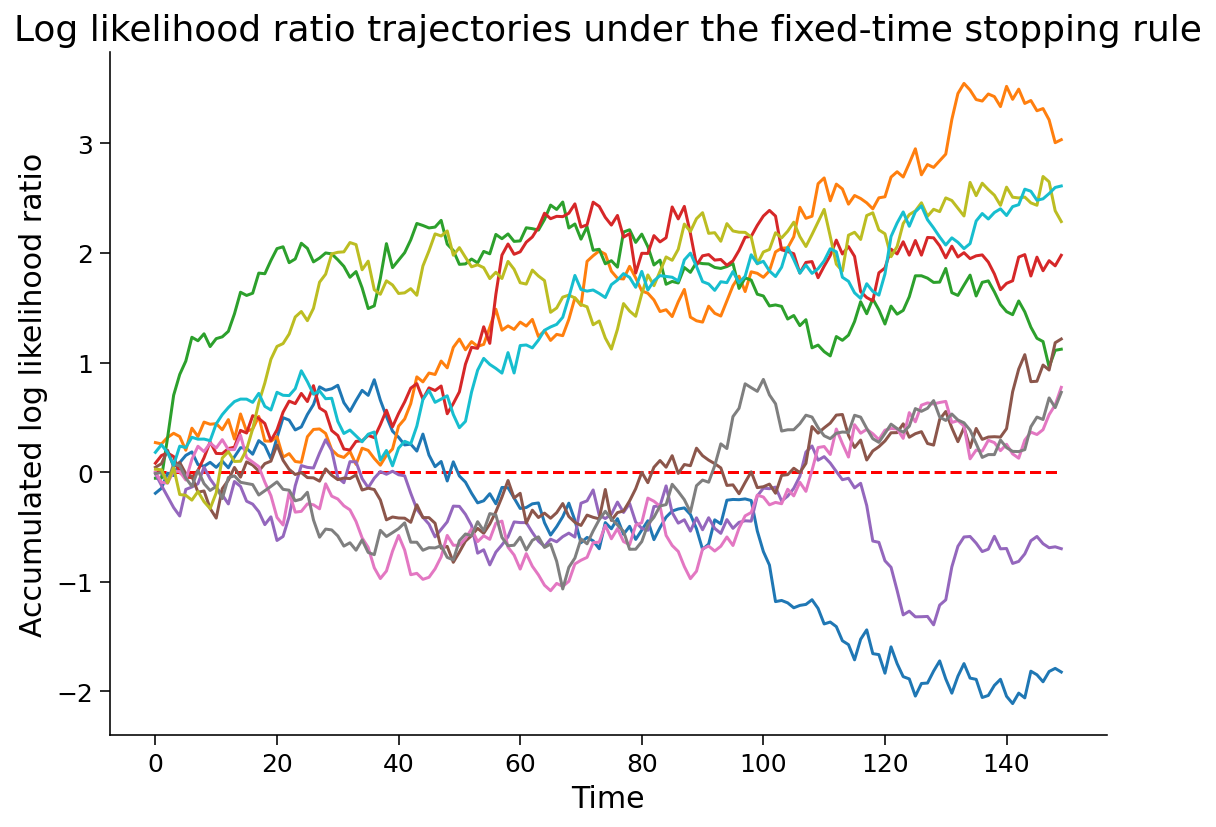

In [6]:
def simulate_SPRT_fixedtime(mu, sigma, stop_time, true_dist = 1):
  """Simulate a Sequential Probability Ratio Test with fixed time stopping
  rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
  N(-1,sigma^2).

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation of observation models
    stop_time (int): Number of samples to take before stopping
    true_dist (1 or -1): Which state is the true state.

  Returns:
    evidence_history (numpy vector): the history of cumulated evidence given
                                      generated data
    decision (int): 1 for s = 1, -1 for s = -1
    Mvec (numpy vector): the generated sequences of measurement data in this trial
  """

  #################################################
  ## TODO for students ##
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: complete simulate_SPRT_fixedtime")
  #################################################

  # Set means of observation distributions
  assert mu > 0, "Mu should be > 0"
  mu_pos = mu
  mu_neg = -mu

  # Make observation distributions
  p_pos = stats.norm(loc = mu_pos, scale = sigma)
  p_neg = stats.norm(loc = mu_neg, scale = sigma)

  # Generate a random sequence of measurements
  if true_dist == 1:
    Mvec = p_pos.rvs(size = stop_time)
  else:
    Mvec = p_neg.rvs(size = stop_time)

  # Calculate log likelihood ratio for each measurement (delta_t)
  ll_ratio_vec = log_likelihood_ratio(Mvec, p_neg, p_pos)

  # STEP 1: Calculate accumulated evidence (S) given a time series of evidence (hint: np.cumsum)
  evidence_history = np.cumsum(ll_ratio_vec)

  # STEP 2: Make decision based on the sign of the evidence at the final time.
  decision = evidence_history[-1]/abs(evidence_history[-1])

  return evidence_history, decision, Mvec


# Set random seed
np.random.seed(100)

# Set model parameters
mu = .2
sigma = 3.5  # standard deviation for p+ and p-
num_sample = 10  # number of simulations to run
stop_time = 150 # number of steps before stopping

# Simulate and visualize
simulate_and_plot_SPRT_fixedtime(mu, sigma, stop_time, num_sample)

In [7]:
# @markdown Make sure you execute this cell to enable the widget!

def simulate_SPRT_fixedtime(mu, sigma, stop_time, true_dist = 1):
  """Simulate a Sequential Probability Ratio Test with fixed time stopping
  rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
  N(-1,sigma^2).

  Args:
    mu (float): absolute mean value of the symmetric observation distributions
    sigma (float): Standard deviation of observation models
    stop_time (int): Number of samples to take before stopping
    true_dist (1 or -1): Which state is the true state.

  Returns:
    evidence_history (numpy vector): the history of cumulated evidence given
                                      generated data
    decision (int): 1 for s = 1, -1 for s = -1
    Mvec (numpy vector): the generated sequences of measurement data in this trial
  """

  # Set means of observation distributions
  assert mu > 0, "Mu should be >0"
  mu_pos = mu
  mu_neg = -mu

  # Make observation distributions
  p_pos = stats.norm(loc = mu_pos, scale = sigma)
  p_neg = stats.norm(loc = mu_neg, scale = sigma)

  # Generate a random sequence of measurements
  if true_dist == 1:
    Mvec = p_pos.rvs(size = stop_time)
  else:
    Mvec = p_neg.rvs(size = stop_time)

  # Calculate log likelihood ratio for each measurement (delta_t)
  ll_ratio_vec = log_likelihood_ratio(Mvec, p_neg, p_pos)

  # STEP 1: Calculate accumulated evidence (S) given a time series of evidence (hint: np.cumsum)
  evidence_history = np.cumsum(ll_ratio_vec)

  # STEP 2: Make decision based on the sign of the evidence at the final time.
  decision = np.sign(evidence_history[-1])

  return evidence_history, decision, Mvec

np.random.seed(100)
num_sample = 10

@widgets.interact(mu=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=0.5), sigma=(0.05, 10.0, 0.05), stop_time=(5, 500, 1))
def plot(mu, sigma, stop_time):
  simulate_and_plot_SPRT_fixedtime(mu, sigma, stop_time, num_sample, verbose=False)

interactive(children=(FloatSlider(value=0.5, description='mu', max=5.0, min=0.1), FloatSlider(value=5.0, descr…

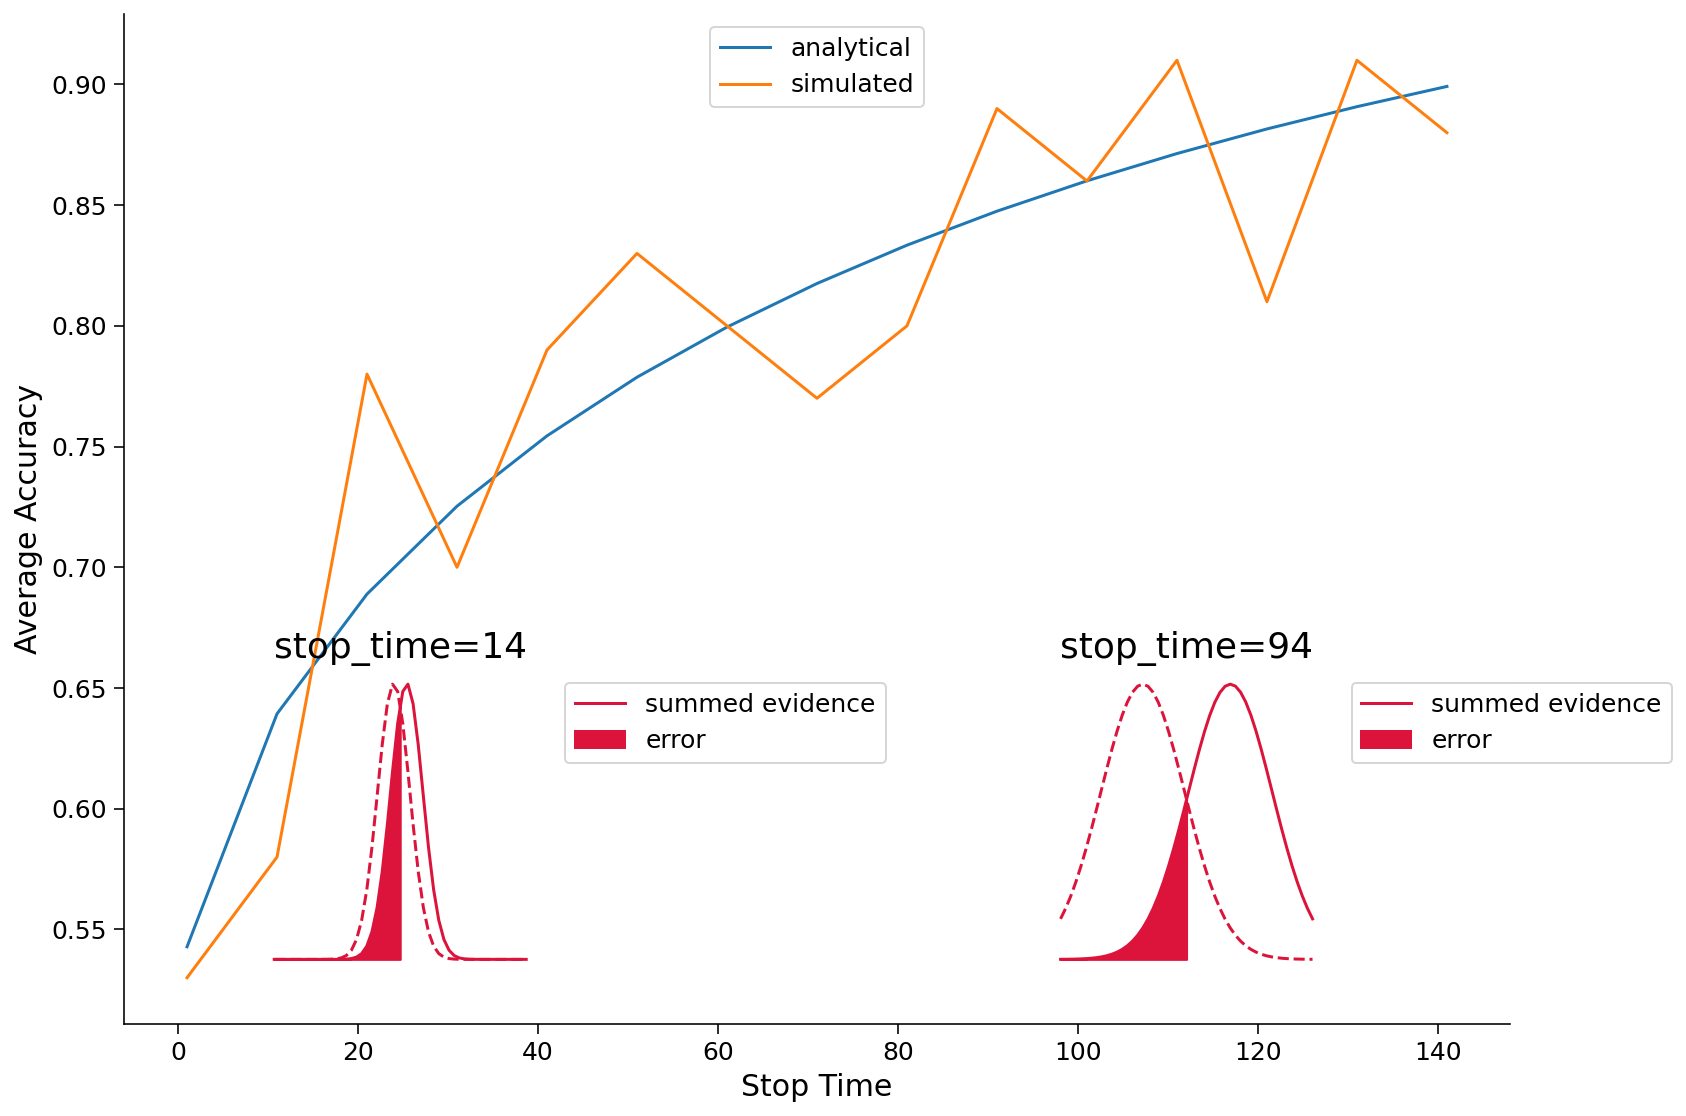

In [12]:
def simulate_accuracy_vs_stoptime(mu, sigma, stop_time_list, num_sample, no_numerical=False):
  """Calculate the average decision accuracy vs. stopping time by running
  repeated SPRT simulations for each stop time.

  Args:
      mu (float): absolute mean value of the symmetric observation distributions
      sigma (float): standard deviation for observation model
      stop_list_list (list-like object): a list of stopping times to run over
      num_sample (int): number of simulations to run per stopping time
      no_numerical (bool): flag that indicates the function to return analytical values only

  Returns:
      accuracy_list: a list of average accuracies corresponding to input
                      `stop_time_list`
      decisions_list: a list of decisions made in all trials
  """

  #################################################
  ## TODO for students##
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: complete simulate_accuracy_vs_stoptime")
  #################################################

  # Determine true state (1 or -1)
  true_dist = 1

  # Set up tracker of accuracy and decisions
  accuracies = np.zeros(len(stop_time_list),)
  accuracies_analytical = np.zeros(len(stop_time_list),)
  decisions_list = []

  # Loop over stop times
  for i_stop_time, stop_time in enumerate(stop_time_list):

    if not no_numerical:
      # Set up tracker of decisions for this stop time
      decisions = np.zeros((num_sample,))

      # Loop over samples
      for i in range(num_sample):

        # STEP 1: Simulate run for this stop time (hint: use output from last exercise)
        _, decision, _= simulate_SPRT_fixedtime(mu, sigma, stop_time, true_dist)

        # Log decision
        decisions[i] = decision

      # STEP 2: Calculate accuracy by averaging over trials
      accuracies[i_stop_time] = np.sum(decisions == true_dist) / decisions.shape[0]

      # Log decision
      decisions_list.append(decisions)

    # Calculate analytical accuracy
    sigma_sum_gaussian = sigma / np.sqrt(stop_time)
    accuracies_analytical[i_stop_time] = 0.5 + 0.5 * erf(mu / np.sqrt(2) / sigma_sum_gaussian)

  return accuracies, accuracies_analytical, decisions_list


# Set random seed
np.random.seed(100)

# Set parameters of model
mu = 0.5
sigma = 4.65  # standard deviation for observation noise
num_sample = 100  # number of simulations to run for each stopping time
stop_time_list = np.arange(1, 150, 10) # Array of stopping times to use


# Calculate accuracies for each stop time
accuracies, accuracies_analytical, _ = simulate_accuracy_vs_stoptime(mu, sigma, stop_time_list,
                                                   num_sample)

# Visualize
plot_accuracy_vs_stoptime(mu, sigma, stop_time_list, accuracies_analytical, accuracies)